# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 24/12/2024\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [1]:
%%capture
# !pip install bertopic accelerate bitsandbytes xformers adjustText
# !pip install llama-cpp-python
# !{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"
import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
# from cuml.manifold import UMAP
# from cuml.cluster import HDBSCAN

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from src.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from configs.dreamachine import config

# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')
torch.cuda.empty_cache()


# Parameters from config
dataset = config.name
transformer_model = config.transformer_model
ngram_range = config.ngram_range
max_df = config.max_df
min_df = config.min_df
top_n_words = config.top_n_words
stop_words = config.extended_stop_words

# Setup parameters
condition = "DL"
sentences = True
reduced_GS = False
random_seed = 42
nr_topics = "auto"


# File paths
data_dir = os.path.join(project_root, "DATA", dataset)
reports_path = os.path.join(data_dir, f"{condition}.csv")

results_dir = os.path.join(project_root, "RESULTS")
results_filename = f"GS_results_{condition}_{'reduced_' if reduced_GS else ''}{'sentences' if sentences else ''}.csv"
results_path = os.path.join(results_dir, results_filename)

# Load data
df_reports = pd.read_csv(reports_path)['reflection_answer']




# Apply sentence splitting if needed
if sentences:
    df_reports = split_sentences(df_reports)

# Get parameters from config
params = config.get_params(condition, reduced_GS)


In [2]:
# Models setup (from configs)
embedding_model = SentenceTransformer(config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)
print(embedding_model)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

Batches: 100%|██████████| 6/6 [00:00<00:00,  7.89it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [3]:
# load grid search results abd get best params
results_GS = pd.read_csv(results_path)
chosen_params = results_GS.iloc[0]
print(chosen_params)

# setup models with best params
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)

hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Run BERTopic
model = setup_model(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=int(chosen_params['top_n_words']),
    nr_topics="auto"
)

topics, probs = model.fit_transform(df_reports, embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


n_components             18.000000
n_neighbors              25.000000
min_dist                  0.025000
min_cluster_size          5.000000
min_samples               5.000000
top_n_words               5.000000
coherence_score           0.574588
cohenrece_score_umass    -8.620037
n_topics                  8.000000
Name: 0, dtype: float64


In [4]:
coherence_score,coherence_score_umass = calculate_coherence(model, df_reports) #sanitary check for coherence, that we obtain the same score as when running GS
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")


#check how many documents identified as outliers
print(len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1]))

Batches: 100%|██████████| 6/6 [00:00<00:00, 18.64it/s]


Number of valid topics used for coherence calculation: 5
Coherence Score: 0.3975994293060696
n = 6 topics extracted
56


In [5]:
#check sentences identified as outliers
# outliers = np.where(model.hdbscan_model.labels_==-1)[0]
# for i in outliers:
#     print(df_reports[i])


In [6]:
new_topics = model.reduce_outliers(df_reports, topics,strategy='probabilities',probabilities=_,threshold=0.1)

# Check the impact
print(f"Original outliers: {len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

#print the sentences that are identified as outliers after reduction
outliers = np.where(np.array(new_topics)==-1)[0]
for i in outliers:
    print(df_reports[i])


Original outliers: 56
Remaining outliers after reduction: 0


In [7]:
topics = new_topics
_, probabilities = model.transform(df_reports)

print(f"Number of unique topics after update: {len(np.unique([t for t in topics if t != -1]))}")
print(f"Number of remaining outliers: {len([t for t in topics if t == -1])}")


Batches: 100%|██████████| 6/6 [00:00<00:00, 18.53it/s]

Number of unique topics after update: 0
Number of remaining outliers: 0


In [8]:
model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [9]:
model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

# LLAMA 3

In [10]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# # !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf

# DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

import datamapplot
import torch
torch.cuda.empty_cache()

# # Remove existing installations
# !pip uninstall -y cudf cuml cugraph cupy rmm

# Install RAPIDS packages in correct order
# !pip install --upgrade rmm-cu12 --extra-index-url=https://pypi.nvidia.com/simple
# !pip install --upgrade cudf-cu12 --extra-index-url=https://pypi.nvidia.com/simple
# !pip install --upgrade cuml-cu12 --extra-index-url=https://pypi.nvidia.com/simple

In [11]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
torch.cuda.empty_cache()
# from cuml.manifold import UMAP  # For UMAP dimensionality reduction
# from cuml.cluster import HDBSCAN  # For clustering with HDBSCAN



In [12]:


# LLaMa setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf",
    cache_dir="model"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

llama_new_context_with_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn

In [13]:


prompt = """Q:
Topic documents:
[DOCUMENTS]

Topic keywords: '[KEYWORDS]'

Find the most appropriate scientific label for this topic based on the above information. The label should:

1. Uses Title Case with proper spacing
2. Avoids abstract interpretations
3. Reflects directly reported phenomena
4. Be concise yet comprehensive (2-5 words max)

Only return the label itself, without any additional text or punctuation.
A:
"""

pipeline_kwargs = {
    "max_tokens": 10, 
    "temperature": 0.3,    # conservative to minimise randomness and hallucinations
    "top_p": 0.7, # Range: 0 to 1. Focus on most probable tokens from the input
    
    "repeat_penalty": 2 
    # >1.0: penalise repeated words, useful for avoiding redundant terms in labels
}

representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt,nr_docs=6,pipeline_kwargs=pipeline_kwargs,diversity=0.3)
}

torch.cuda.empty_cache()

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  nr_topics = "auto",
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


In [14]:
# outlier reduction using embeddingd
new_topics = topic_model.reduce_outliers(df_reports, topics,strategy='embeddings',threshold=0.5)

# Check the impact
print(f"Original outliers: {len(topic_model.hdbscan_model.labels_[topic_model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

topic_model.topics_ = new_topics

topics = new_topics




Original outliers: 56
Remaining outliers after reduction: 23


In [15]:



llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in new_topics] 

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics (outliers)



#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)


In [16]:
topic_labels

{0: 'Visual Perception Phenomena',
 1: 'Deep Space Experience',
 2: 'Meditation Experience',
 3: 'Music Perception',
 4: 'Spiritual Awakening'}

In [17]:
topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True)

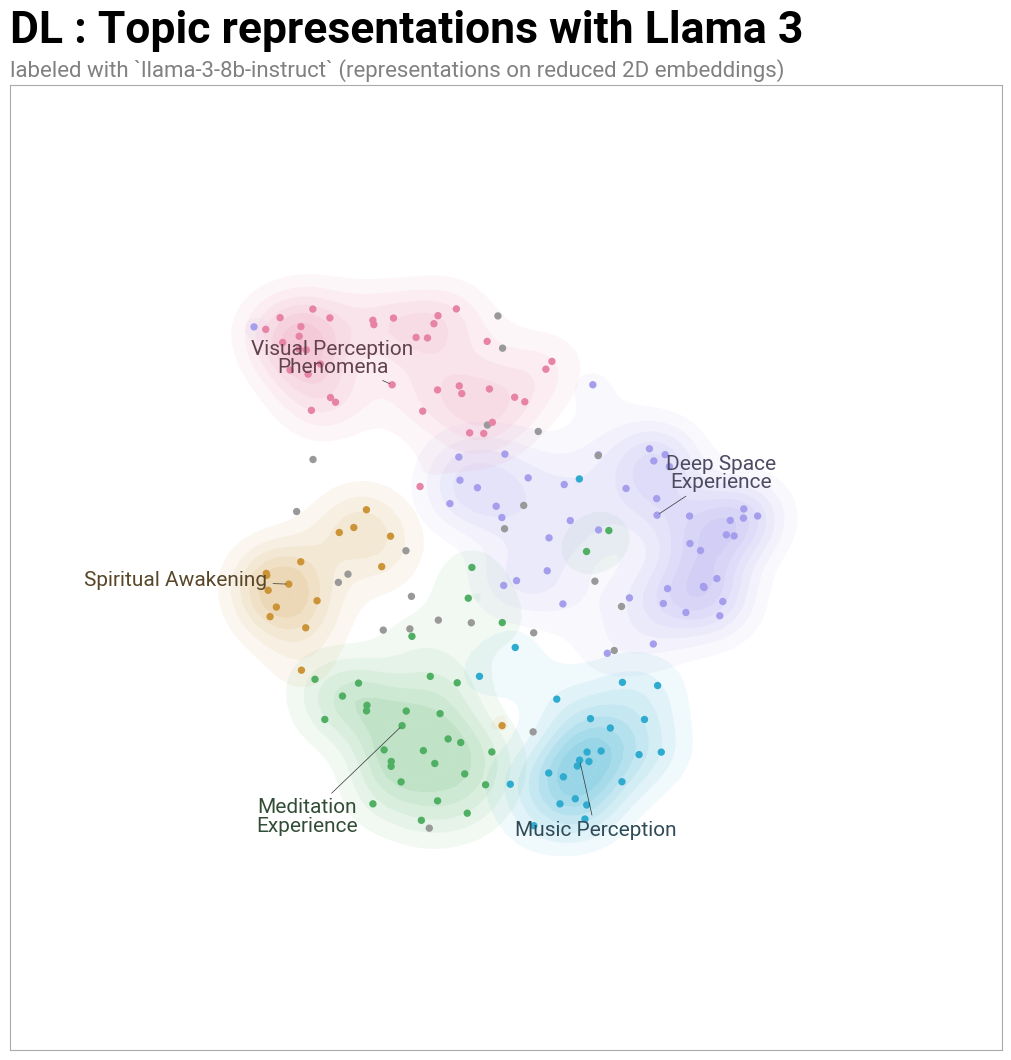

In [18]:

# Reduce embeddings for visualization
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']), 
    n_components=2,
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=42
).fit_transform(embeddings)


# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition} : Topic representations with Llama 3",
   sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [19]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.9)
hierarchy_vis

In [23]:
# create df with topic statistics and content
topic_analysis = pd.DataFrame({
    'Topic_Label': all_labels,
    'Topic_Content': df_reports,
    'Topic_Number': topics
}).reset_index()

# get topic counts and contents
topic_summary = (
    topic_analysis
    .groupby(['Topic_Label', 'Topic_Number'])
    .agg({
        'index': 'count',  # count of sentences
        'Topic_Content': lambda x: list(x)  # list of all sentences
    })
    .rename(columns={'index': 'Sentence_Count'})
    .sort_values('Sentence_Count', ascending=False)
    .reset_index()
)

# # Print summary for each topic
# for _, row in topic_summary.iterrows():
#     print(f"\n{'='*80}")
#     print(f"Topic Label: {row['Topic_Label']}")
#     print(f"Number of sentences: {row['Sentence_Count']}")
#     print("\nSentences in this topic:")
#     for i, sentence in enumerate(row['Topic_Content'], 1):
#         print(f"{i}. {sentence}")


results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
topic_summary.to_csv(results_file, index=False)

print("\nSummary DataFrame:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])


Summary DataFrame:
                   Topic_Label  Topic_Number  Sentence_Count
0        Deep Space Experience             1              46
1  Visual Perception Phenomena             0              38
2        Meditation Experience             2              32
3             Music Perception             3              25
4                   Unlabelled            -1              23
5          Spiritual Awakening             4              16


In [21]:
def create_topic_summary(topic_labels, df_reports, topics):
    """
    create a dataframe with the topic assignments
    """
    topic_analysis = pd.DataFrame({
        'Topic_Content': df_reports,
        'Topic_Number': topics
    })
    

    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels)

    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg({
            'Topic_Content': [
                ('Sentence_Count', 'count'),
                ('Content', list)
            ]
        })
        .reset_index()
    )
    
    topic_summary.columns = ['Topic_Label', 'Topic_Number', 'Sentence_Count', 'Content']
    topic_summary = topic_summary.sort_values('Sentence_Count', ascending=False)
    
    return topic_summary

topic_summary = create_topic_summary(topic_labels, df_reports, topics)


print("\nSummary DataFrame:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])


Summary DataFrame:
                   Topic_Label  Topic_Number  Sentence_Count
0        Deep Space Experience             1              46
4  Visual Perception Phenomena             0              38
1        Meditation Experience             2              32
2             Music Perception             3              25
3          Spiritual Awakening             4              16
